In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras import optimizers
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

rcParams.update({'font.size':10})
plt.rcParams['figure.figsize'] = [12, 12]

Using TensorFlow backend.


(101,)


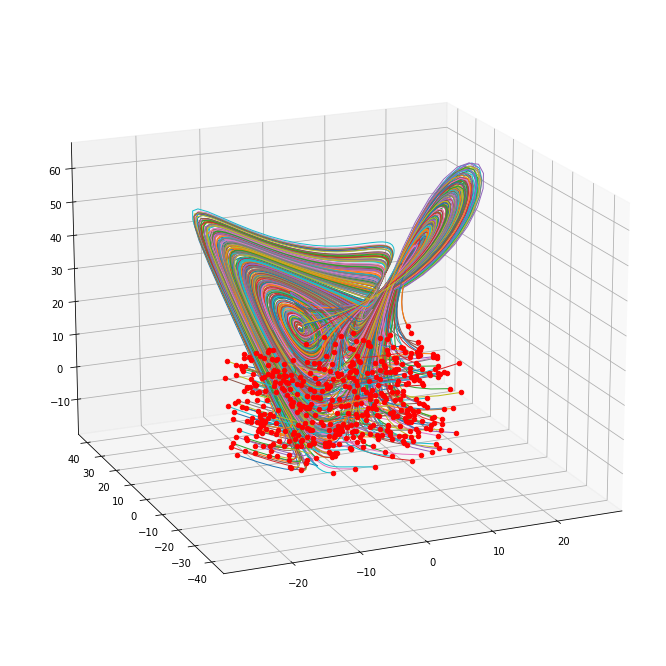

(101,) (101,) (101,)
x_t shape (480, 101, 3)
(48000, 3) 48000 3
(48000, 3) 48000 3
(48000, 3) 48000 3


In [2]:
## Simulate the Lorenz System

dt = 0.01
T = 1 #8
t = np.arange(0, T+dt, dt)
beta = 8/3
sigma = 10
rho = 28

number_traj = 480 #60

print(t.shape)

nn_input = np.zeros((number_traj*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

np.random.seed(123)
x0 = -15+30*np.random.random((number_traj,3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                 for x0_j in x0])

for j in range(number_traj):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z, linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
    
ax.view_init(18,-113)
plt.show()

print(x.shape, y.shape, z.shape)

print('x_t shape',x_t.shape)
# Approximate derivative using finite difference
NN_output = (nn_output-nn_input)/dt
#NN_output = np.zeros(len(nn_output),dtype='complex_')
#for kappa in range(len(nn_output)-1):
    #NN_output[kappa] = (nn_output[kappa+1]-nn_output[kappa])/dt

# Print and Save input and output data for training
print(nn_input.shape,len(nn_input),len(nn_input[0]))
print(nn_output.shape,len(nn_output),len(nn_output[0]))
print(NN_output.shape,len(NN_output),len(NN_output[0]))
#np.savetxt('lorenz_input_data',nn_input)
#np.savetxt('lorenz_output_data',NN_output)
#print(open("lorenz_input_data").read())

In [3]:
import pandas as pd

#X_lorenz_data = np.asarray([ x, y, z ]).T
print(nn_input.shape)
print(nn_output.shape)
row = np.array(['x', 'y', 'z']).T
row_n = row.shape[0] ##last row
#X_lorenz_data1 = np.append(row,[X_lorenz_data1],axis=0)
#X_lorenz_data1 = np.insert(X_lorenz_data1,row_n,[row],axis=0)
#print(nn_input, nn_output)
# Create the pandas DataFrame
X_lorenz_input_dataframe = pd.DataFrame(nn_input, columns=['x', 'y', 'z'])
#X_lorenz_input_dataframe.set_index('index', drop=True, inplace=True)
X_lorenz_input_dataframe.index.names = ['index']
X_lorenz_input_dataframe.to_csv('lorenz_input_data.csv')
#X_lorenz_output_dataframe = pd.DataFrame(NN_output, columns=['dotx', 'doty', 'dotz'])
X_lorenz_output_dataframe = pd.DataFrame(nn_output, columns=['x', 'y', 'z'])
X_lorenz_output_dataframe.index.names = ['index']
X_lorenz_output_dataframe.to_csv('lorenz_output_data.csv')
#x0 = initial conditions
x0_lorenz_input_dataframe = pd.DataFrame(x0, columns=['x', 'y', 'z'])
#X_lorenz_input_dataframe.set_index('index', drop=True, inplace=True)
x0_lorenz_input_dataframe.index.names = ['index']
x0_lorenz_input_dataframe.to_csv('lorenz_input_init_data.csv')
#np.savetxt("lorenz_data.csv", X_lorenz_dataframe, delimiter=",")
#lorenz_data = pd.read_csv("lorenz_data.csv", header=None)
#lorenz_data.to_csv("lorenz_data.csv", header=["x", "y", "z"], index=False)
 
# print dataframes.
X_lorenz_input_dataframe
X_lorenz_output_dataframe
x0_lorenz_input_dataframe

(48000, 3)
(48000, 3)


,x,y,z
index,,,
0,5.894076,-6.415820,-8.194456
1,1.539443,6.584069,-2.306806
2,14.422926,5.544892,-0.572043
3,-3.236474,-4.704660,6.871491
4,-1.842833,-13.209663,-3.058672
...,...,...,...
475,-13.879351,9.146450,10.957335
476,0.371387,-3.642186,-12.495627
477,9.848279,-14.890234,-4.695399


In [4]:
# Build model
deep_approx = Sequential()
deep_approx.add(layers.Dense(10, input_dim=3, activation='relu'))
deep_approx.add(layers.Dense(10, activation='relu'))
deep_approx.add(layers.Dense(3, activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
History = deep_approx.fit(nn_input, nn_output, epochs=20)
                          #batch_size=50,
                          #validation_data=(nn_input, nn_output))
                          #callbacks=keras.callbacks.EarlyStopping(patience=20))

Epoch 1/20
48000/48000 [==============================] - 3s 61us/step - loss: 30.8709
Epoch 2/20
48000/48000 [==============================] - 2s 50us/step - loss: 0.5735
Epoch 3/20
48000/48000 [==============================] - 2s 46us/step - loss: 0.3281
Epoch 4/20
48000/48000 [==============================] - 2s 51us/step - loss: 0.2585
Epoch 5/20
48000/48000 [==============================] - 2s 52us/step - loss: 0.2277
Epoch 6/20
48000/48000 [==============================] - 3s 57us/step - loss: 0.2050
Epoch 7/20
48000/48000 [==============================] - 2s 48us/step - loss: 0.1669
Epoch 8/20
48000/48000 [==============================] - 2s 42us/step - loss: 0.1429
Epoch 9/20
48000/48000 [==============================] - 2s 50us/step - loss: 0.1302
Epoch 10/20
48000/48000 [==============================] - 2s 49us/step - loss: 0.1211
Epoch 11/20
48000/48000 [==============================] - 2s 49us/step - loss: 0.1108
Epoch 12/20
48000/48000 [==========================

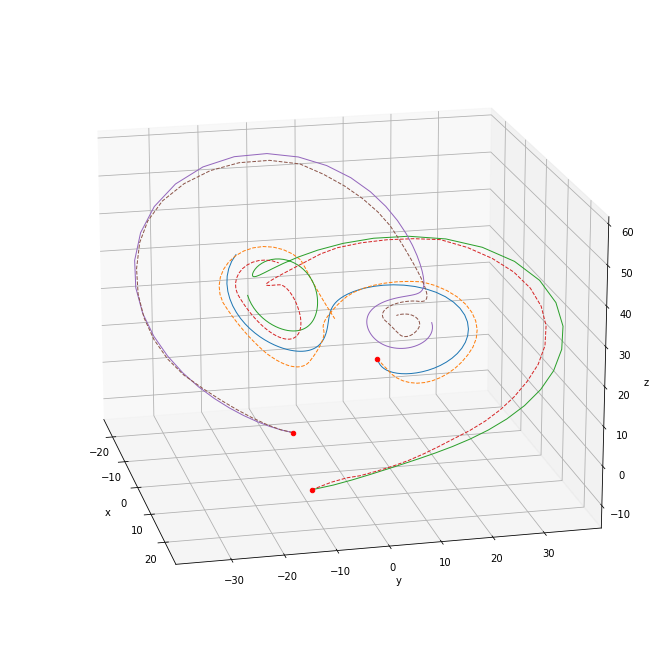

In [5]:
# from tqdm import tqdm
np.random.seed(139)
num_traj = 3

nn_flow = np.zeros((num_traj, len(t), 3))
nn_flow[:, 0, :] = -15 + 30*np.random.random((num_traj,3))
for jj, tval in enumerate(t[:-1]):
    nn_flow[:, jj+1,:] = deep_approx.predict(nn_flow[:, jj, :])
    
#x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                 #for x0_j in x0])

x_t = np.asarray([integrate.odeint(lorenz_deriv, nn_flow[i, 0, :], t)
                  for i in range(num_traj)])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in range(num_traj):
    x, y, z = x_t[j,:,:].T
    xd, yd, zd = nn_flow[j,:,:].T
    ax.plot(x, y, z, linewidth=1)
    ax.plot(xd, yd, zd, '--', lw=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x[0], y[0], z[0], color='r')
    
ax.view_init(18, -13)
plt.show()

In [6]:
#import random
#amnt = int(input('Enter the amount of # you would like:'))
#data = (random.randint(0,1000) for _ in range(amnt))
#data = (str(datum) for datum in data)
#data = ','.join(data) + '\n'
#with open("random.csv", "w") as fp:
#    fp.write(data)